# Importing

In [19]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import block_diag
import cvxpy as cp

import networkx as nx

from random import choice

from numpy.linalg import inv, pinv

plt.rcParams.update({'font.size': 14})

\begin{align*}
\min_{w_1, \ldots, w_K} & \sum\limits_{k=1}^{K} (w_k^\top R_k w_k + r_k^\top w_k) \\
\mathrm{s.t.} & \sum\limits_{k \in N_e} B_{e, k} w_k = b_e, \quad \forall e = 1, \ldots, E
\end{align*}

# Constants

In [20]:
K = 20
Q_k = 10

R_array = []
for k in range(K):
    #R_k = np.random.randn(Q_k, Q_k)
    #R_k = R_k.T @ R_k
    #R_k = 2 * np.diag(np.ones(Q_k), k = 0) + np.diag(np.ones(Q_k-1), k = 1) + np.diag(np.ones(Q_k-1), k = -1)
    #ev = np.linalg.eigvals(R_k)
    #eva = [abs(x) for x in ev]
    #print(max(eva) - min(eva))
    R_k = 1.5 * np.identity(Q_k)
    R_array.append(R_k)

R_array = np.array(R_array)


r_array = []
for k in range(K):
    r_k = np.random.randint(low = -2, high = 3, size = Q_k)
    r_array.append(r_k)
    

b_e = np.random.randint(low = -1, high = 2, size = K)

In [21]:
S_e = 1

G = [[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
     [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
     [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]

G = np.array(G)
G_I = G + np.identity(K)
N = [int(G_I.sum(axis=1)[i]) for i in range(K)]

B_matrix = []
for e in range(K):
    B_array = []
    for k in range(K):
        if k in np.nonzero(G_I[e])[0]:
            B_ek = np.random.randint(low = -2, high = 3, size = (S_e, Q_k))
            B_array.append(B_ek)
        else: 
            B_array.append(np.zeros((S_e, Q_k)))
            
    B_matrix.append(B_array)

# Solving via CVXPY

In [22]:
w = cp.Variable(Q_k*K)

R = block_diag(*R_array)
r = np.hstack(tuple(r_array))

func = cp.quad_form(w, R) + r @ w

constraints = []
for e in range(K):
    constraints.append(np.hstack(tuple(B_matrix[e])) @ w == b_e[e])


obj = cp.Minimize(func)

prob = cp.Problem(obj, constraints)
prob.solve()
w_opt = w.value

# Dual Coupled Diffusion

In [23]:
E = K

In [24]:
def MetropolisWeights(E):
    d = E.sum(axis=1)
    W = np.zeros((E.shape[0], E.shape[1]))
    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            if i == j:
                continue
            else:
                if E[i][j] == 1:
                    W[i][j] = 1 / (1 + max(d[i], d[j]))
                else:
                    W[i][j] = 0
        W[i][i] = 1 - W[i].sum()
    return W

In [25]:
A_array = []

for e in range(E):
    lst_e = np.nonzero(G_I[e])[0]
    A_e = MetropolisWeights(G[np.ix_(lst_e, lst_e)])
    A_array.append(A_e)

In [26]:
MetropolisWeights(G[np.ix_(lst_e, lst_e)])

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [27]:
A_bar_array = []
for e in range(K):
    A_bar_array.append(np.kron(1/2*(np.identity(N[e]) + A_array[e]), np.identity(S_e)))
    
A_bar = block_diag(*A_bar_array)

In [28]:
B_bar_matrix = []
for e in range(E):
    B_bar_array = []
    for k in range(K):
        B = []
        for k_bar in np.nonzero(G_I[e])[0]:
            if k in np.nonzero(G_I[e])[0] and k == k_bar:
                B.append(B_matrix[e][k].T)
            else: 
                B.append(np.zeros((Q_k, S_e)))
        B_bar_array.append(np.hstack(tuple(B)))
    B_bar_matrix.append(B_bar_array)

In [29]:
B_bar_matrix_T = [[None for k in range(K)] for e in range(E)]

for e in range(E):
    for k in range(K):
        B_bar_matrix_T[e][k] = B_bar_matrix[k][e]
        
B_T = np.block(B_bar_matrix_T)
B = B_T.T

In [30]:
B_T.shape

(200, 66)

In [37]:
b = np.hstack(tuple([1/N[e]*(np.kron(np.ones(N[e]), b_e[e])) for e in range(E)]))

In [38]:
def J(k, w_k):
    return w_k @ R_array[k] @ w_k + r_array[k] @ w_k

In [39]:
def grad_J(k, w_k):
    return 2 * R_array[k] @ w_k + r_array[k]

In [40]:
def parse(w):
    return [w[k*Q_k:(k+1)*Q_k] for k in range(K)]

In [41]:
def grad_J_bar(w):
    lst_w_k = parse(w)
    return np.hstack(tuple([grad_J(k, lst_w_k[k]) for k in range(K)]))

In [42]:
def Dual_Coupled_Diffusion(mu_w = 0.1, mu_y = 0.2, wm1 = np.ones(Q_k*K), ym1 = np.ones(sum(N)), n_iter = 1000):
    w0 = wm1 - mu_w * grad_J_bar(wm1) - mu_w * B_T @ ym1
    y0 = ym1 + mu_y * (B @ w0 - b)
    
    w_i = np.zeros((n_iter, Q_k*K))
    w_i[0] = wm1
    w_i[1] = w0
    y_i = np.zeros((n_iter, sum(N)))
    y_i[0] = ym1
    y_i[1] = y0
    
    for i in range(2, n_iter):
        w_i[i] = w_i[i-1] - mu_w * grad_J_bar(w_i[i-1]) - mu_w * B_T @ y_i[i-1]
        y_i[i] = A_bar @ (2*y_i[i-1] - y_i[i-2] + mu_y * B @ (w_i[i] - w_i[i-1]))
    return w_i, y_i

In [43]:
w_i_DCD, y_i_DCD = Dual_Coupled_Diffusion(mu_w = 0.1, mu_y = 0.2, wm1 = np.ones(Q_k*K), ym1 = np.ones(sum(N)), n_iter = 1000)

# Dual Diffusion

In [49]:
E = 1
S_e = 20

In [50]:
# переделываем ограничение, теперь оно одно:
B_stack_matrix = []
for k in range(K):
    B_stack_matrix.append(np.vstack(tuple([B_matrix[e][k] for e in range(K)])))

In [51]:
A_array = []

A_e = MetropolisWeights(G)
A_array.append(A_e)

In [52]:
A_bar_array = []
for e in range(E):
    A_bar_array.append(np.kron(1/2*(np.identity(K) + A_array[e]), np.identity(S_e)))
    
A_bar = block_diag(*A_bar_array)

In [53]:
B_bar_matrix = []

for k in range(K):
    B = []
    for k_bar in range(K):
        if k in range(K) and k == k_bar:
            B.append(B_stack_matrix[k].T)
        else: 
            B.append(np.zeros((Q_k, S_e)))
    B_bar_matrix.append(np.hstack(tuple(B)))

In [54]:
B_T = np.vstack(B_bar_matrix)
B = B_T.T 

In [55]:
b = 1/K*(np.kron(np.ones(K), b_e))

In [56]:
def Dual_Diffusion(mu_w = 0.1, mu_y = 0.2, wm1 = np.ones(Q_k*K), ym1 = np.ones(K*S_e), n_iter = 1000):
    w0 = wm1 - mu_w * grad_J_bar(wm1) - mu_w * B_T @ ym1
    y0 = ym1 + mu_y * (B @ w0 - b)
    
    w_i = np.zeros((n_iter, Q_k*K))
    w_i[0] = wm1
    w_i[1] = w0
    y_i = np.zeros((n_iter, K*S_e))
    y_i[0] = ym1
    y_i[1] = y0
    
    for i in range(2, n_iter):
        w_i[i] = w_i[i-1] - mu_w * grad_J_bar(w_i[i-1]) - mu_w * B_T @ y_i[i-1]
        y_i[i] = A_bar @ (2*y_i[i-1] - y_i[i-2] + mu_y * B @ (w_i[i] - w_i[i-1]))
    return w_i, y_i

In [27]:
w_i_DD, y_i_DD = Dual_Diffusion(mu_w = 0.1, mu_y = 0.2, wm1 = np.ones(Q_k*K), ym1 = np.ones(K*S_e), n_iter = 1000)

# Comparison

Text(0, 0.5, 'Squared error')

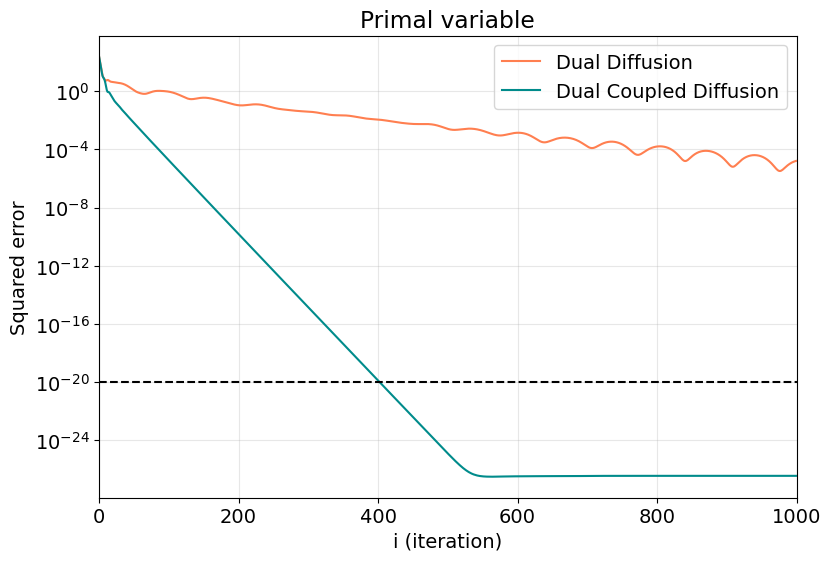

In [28]:
plt.figure(figsize=(9, 6))

plt.plot(range(w_i_DD.shape[0]), [np.linalg.norm(w_i_DD[i] - w_opt)**2 for i in range(w_i_DD.shape[0])], 
         label = 'Dual Diffusion', color = 'coral')
plt.plot(range(w_i_DCD.shape[0]), [np.linalg.norm(w_i_DCD[i] - w_opt)**2 for i in range(w_i_DCD.shape[0])], 
         label = 'Dual Coupled Diffusion', color = 'darkcyan')

plt.xlim(0, 1000)
plt.axhline(y = 1e-20, color = 'black', linestyle='--')
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("i (iteration)")
plt.ylabel("Squared error")

# Proximal Dual Coupled Dissufion

\begin{align*}
\min_{w_1, \ldots, w_K} & \sum\limits_{k=1}^{K} (w_k^\top R_k w_k + r_k^\top w_k) + \mathcal{I}_{k}(w_k) \\
\mathrm{s.t.} & \sum\limits_{k \in N_e} B_{e, k} w_k = b_e, \quad \forall e = 1, \ldots, E
\end{align*}

Actually, $\mathcal{I}_{k}(\cdot)$ doesn't have to be an indicator of a local constraints set. $\mathcal{I}_{k}(\cdot): \mathbb{R}^{Q_k} \to \mathbb{R} \cup \{ + \infty \}$ is a convex function possibly non-smooth.

In [44]:
# CVXPY

w = cp.Variable(Q_k*K)

R = block_diag(*R_array)
r = np.hstack(tuple(r_array))

func = cp.quad_form(w, R) + r @ w

constraints = [w >= -1,
               w <= 1]

for e in range(K):
    constraints.append(np.hstack(tuple(B_matrix[e])) @ w == b_e[e])

obj = cp.Minimize(func)

prob = cp.Problem(obj, constraints)
prob.solve()
w_opt = w.value

In [45]:
def I(k, w_k):
    if np.all(w_k <= 1) and np.all(w_k >= -1):
        return 0
    else:
        return np.inf

$$
\mathrm{prox}_{\mu I} (x) = \arg\min_{u} \left( I(u) + \dfrac{1}{2\mu} \| x - u \|^2 \right)
$$

In our case $\mathcal{I}(w) = \sum\limits_{k=1}^{K} \mathcal{I}_k (w_k)$ is an indicator of a cube $[-1, 1] \times \ldots \times [-1, 1]$. Therefore, $\mathrm{prox}$ is a projection on this cube.

In [8]:
def prox(x):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] < -1:
            y[i] = -1
        elif -1 <= x[i] <= 1:
            y[i] = x[i]
        elif x[i] > 1:
            y[i] = 1
    return y

In [47]:
def Proximal_Dual_Coupled_Diffusion(mu_w = 0.1, mu_y = 0.2, wm1 = np.ones(Q_k*K), ym1 = np.ones(sum(N)), n_iter = 1000):
    w0 = prox(wm1 - mu_w * grad_J_bar(wm1) - mu_w * B_T @ ym1)
    y0 = ym1 + mu_y * (B @ w0 - b)
    
    w_i = np.zeros((n_iter, Q_k*K))
    w_i[0] = wm1
    w_i[1] = w0
    y_i = np.zeros((n_iter, sum(N)))
    y_i[0] = ym1
    y_i[1] = y0
    
    for i in range(2, n_iter):
        w_i[i] = prox(w_i[i-1] - mu_w * grad_J_bar(w_i[i-1]) - mu_w * B_T @ y_i[i-1])
        y_i[i] = A_bar @ (2 * y_i[i-1] - y_i[i-2] + mu_y * B @ (w_i[i] - w_i[i-1]))
    return w_i, y_i

In [48]:
w_i_PDCD, y_i_PDCD = Proximal_Dual_Coupled_Diffusion(mu_w = 0.1, mu_y = 0.2, wm1 = np.ones(Q_k*K), ym1 = np.ones(sum(N)), n_iter = 1000)

# Proximal Dual Diffusion

In [57]:
E = 1
S_e = 20

In [58]:
# переделываем ограничение, теперь оно одно:
B_stack_matrix = []
for k in range(K):
    B_stack_matrix.append(np.vstack(tuple([B_matrix[e][k] for e in range(K)])))

In [59]:
A_array = []

A_e = MetropolisWeights(G)
A_array.append(A_e)

In [60]:
A_bar_array = []
for e in range(E):
    A_bar_array.append(np.kron(1/2*(np.identity(K) + A_array[e]), np.identity(S_e)))
    
A_bar = block_diag(*A_bar_array)

In [61]:
B_bar_matrix = []

for k in range(K):
    B = []
    for k_bar in range(K):
        if k in range(K) and k == k_bar:
            B.append(B_stack_matrix[k].T)
        else: 
            B.append(np.zeros((Q_k, S_e)))
    B_bar_matrix.append(np.hstack(tuple(B)))

In [62]:
B_T = np.vstack(B_bar_matrix)
B = B_T.T 

In [63]:
b = 1/K*(np.kron(np.ones(K), b_e))

In [64]:
def Proximal_Dual_Diffusion(mu_w = 0.1, mu_y = 0.2, wm1 = np.ones(Q_k*K), ym1 = np.ones(K*S_e), n_iter = 1000):
    w0 = prox(wm1 - mu_w * grad_J_bar(wm1) - mu_w * B_T @ ym1)
    y0 = ym1 + mu_y * (B @ w0 - b)
    
    w_i = np.zeros((n_iter, Q_k*K))
    w_i[0] = wm1
    w_i[1] = w0
    y_i = np.zeros((n_iter, K*S_e))
    y_i[0] = ym1
    y_i[1] = y0
    
    for i in range(2, n_iter):
        w_i[i] = prox(w_i[i-1] - mu_w * grad_J_bar(w_i[i-1]) - mu_w * B_T @ y_i[i-1])
        y_i[i] = A_bar @ (2*y_i[i-1] - y_i[i-2] + mu_y * B @ (w_i[i] - w_i[i-1]))
    return w_i, y_i

In [65]:
w_i_PDD, y_i_PDD = Proximal_Dual_Diffusion(mu_w = 0.1, mu_y = 0.2, wm1 = np.ones(Q_k*K), ym1 = np.ones(K*S_e), n_iter = 1000)

# Comparison

Text(0, 0.5, 'Squared error')

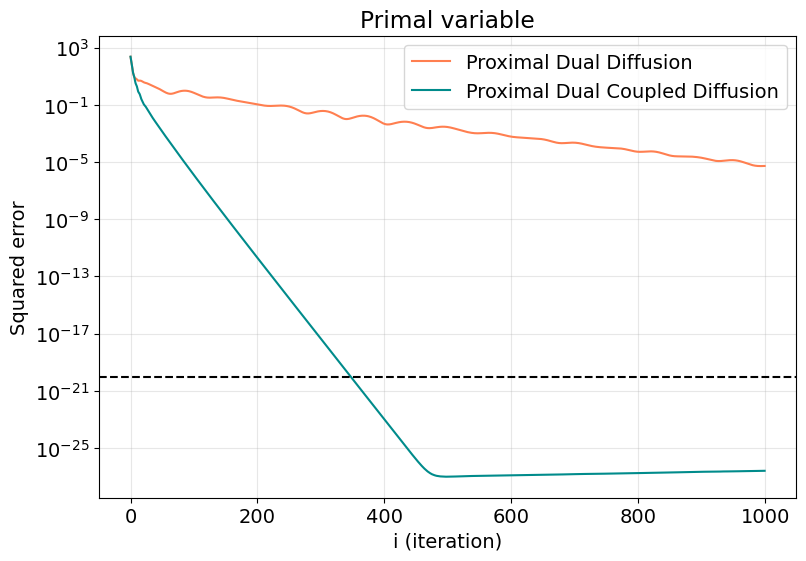

In [66]:
plt.figure(figsize=(9, 6))

plt.plot(range(w_i_PDD.shape[0]), [np.linalg.norm(w_i_PDD[i] - w_opt)**2 for i in range(w_i_PDD.shape[0])], 
         label = 'Proximal Dual Diffusion', color = 'coral')

plt.plot(range(w_i_PDCD.shape[0]), [np.linalg.norm(w_i_PDCD[i] - w_opt)**2 for i in range(w_i_PDCD.shape[0])], 
         label = 'Proximal Dual Coupled Diffusion', color = 'darkcyan')

#plt.xlim(0, 1000)
plt.axhline(y = 1e-20, color = 'black', linestyle='--')
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("i (iteration)")
plt.ylabel("Squared error")

# PJ-ADMM-LC

In [67]:
N = 20 # number of agents
H = 10 # dim x_n
M = 20 # dim b

#C = np.random.randint(low=100, size=(N*H, N*H))
#C = C.T @ C + 100 * np.identity(N*H)
C = R
q = r

A_array = B_stack_matrix

A = np.block(B_matrix)
b = b_e

alpha = 1e-3

Q_array = []

for n in range(N):
    Q_n = alpha * (N - 1) * (A_array[n].T @ A_array[n]) + 1 * np.identity(H)
    #print(np.all(np.linalg.eigvals(Q_n) > 0))
    Q_array.append(Q_n)

Q_array = np.array(Q_array)

In [68]:
def f(x):
    return x @ C @ x + q @ x

In [69]:
def newton(theta_0: np.ndarray, n_iters: int, F, grad_F, hess_F):
    #flog = []
    theta = theta_0
    hessian = hess_F(theta)
    pinv_hessian = inv(hessian)
    for _ in range(n_iters):
        #flog.append(F(theta))
        theta = prox(theta - pinv_hessian @ grad_F(theta))
    return theta

In [70]:
def PJ_ADMM_LC(x0, l0, n_iter, P, tau, alpha, Q_array):

    A_hat = block_diag(*A_array)
    b_hat = np.kron(np.ones(N), b)
    P_Ntau = np.kron(np.linalg.matrix_power(P, tau), np.identity(M))
    I_NM = np.identity(N*M)
    Q = block_diag(*Q_array)

    x_k = np.zeros((n_iter, N*H))
    l_k = np.zeros((n_iter, N*M))

    x_k[0] = x0
    l_k[0] = l0

    k = 0

    while k <= n_iter-2:

        def F(x):
            return f(x) + alpha / 2 * np.linalg.norm(A_hat @ x + (N * P_Ntau - I_NM) @ A_hat @ x_k[k] - b_hat + P_Ntau @ l_k[k] / alpha) ** 2 + 1 / 2 * (x - x_k[k]) @ Q @ (x - x_k[k])

        def grad_F(x):
            return (2*C + Q + alpha * A_hat.T @ A_hat) @ x + q + alpha * A_hat.T @ ((N * P_Ntau - I_NM) @ A_hat @ x_k[k] - b_hat + P_Ntau @ l_k[k] / alpha) - Q @ x_k[k]
        
        def hess_F(x):
            return 2*C + Q + alpha * A_hat.T @ A_hat

        x_k[k+1] = newton(x_k[k], 1, F, grad_F, hess_F)

        l_k[k+1] = P_Ntau @ l_k[k] + alpha * (P_Ntau @ A_hat @ x_k[k] - b_hat)

        k = k + 1

    return x_k, l_k

In [71]:
w0 = np.ones(N*H)
y0 = np.ones(N*M)
n_iter = 1000
P = MetropolisWeights(G)

w_i_ADMM, y_i_ADMM = PJ_ADMM_LC(w0, y0, n_iter, P, 5, alpha, Q_array)

Text(0, 0.5, 'Squared error')

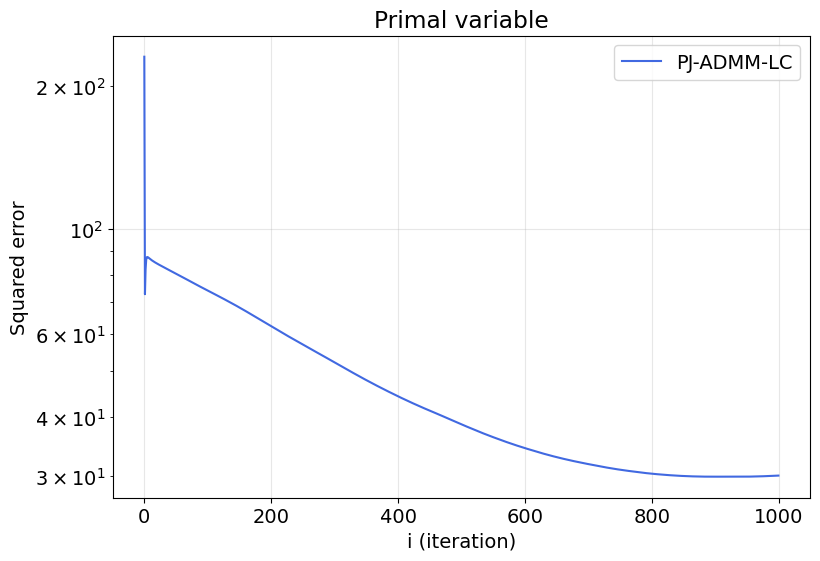

In [72]:
plt.figure(figsize=(9, 6))

#plt.plot(range(w_i_PDD.shape[0]), [np.linalg.norm(w_i_PDD[i] - w_opt)**2 for i in range(w_i_PDD.shape[0])], 
         #label = 'Proximal Dual Diffusion', color = 'coral')

#plt.plot(range(w_i_PDCD.shape[0]), [np.linalg.norm(w_i_PDCD[i] - w_opt)**2 for i in range(w_i_PDCD.shape[0])], 
         #label = 'Proximal Dual Coupled Diffusion', color = 'darkcyan')

plt.plot(range(w_i_ADMM.shape[0]), [np.linalg.norm(w_i_ADMM[i] - w_opt)**2 for i in range(w_i_ADMM.shape[0])], 
         label = 'PJ-ADMM-LC', color = 'royalblue')

#plt.xlim(0, 1000)
#plt.axhline(y = 1e-20, color = 'black', linestyle='--')
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("i (iteration)")
plt.ylabel("Squared error")